In [1]:
# IMPORTING LIBRARIES
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns                                   # For pretty plot
from datetime import datetime, timedelta

from sklearn import datasets, linear_model
from sklearn.cross_validation import cross_val_predict

from itertools import product

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.max_columns = 50

In [2]:
import pickle

## Load DataFrame of all irradiance means

In [3]:
irradMean_df = pickle.load(open('irradMean_df.p', 'rb'))

In [4]:
irradMean_df.head(10)

,time,gre000z0
stn,,
TAE,200001010000,0
TAE,200001010010,0
TAE,200001010020,0
TAE,200001010030,0
TAE,200001010040,12
TAE,200001010050,0
TAE,200001010100,0
TAE,200001010110,0
TAE,200001010120,0


In [5]:
irradMean_df.tail()

,time,gre000z0
stn,,
KLO,201512312310,2
KLO,201512312320,2
KLO,201512312330,2
KLO,201512312340,2
KLO,201512312350,2


In [6]:
irradMean_df.shape

(86541087, 2)

## Pre-processing

Some rows are the headers, remove them

In [7]:
irradMean_df = irradMean_df[irradMean_df.time != 'time']

In [8]:
irradMean_df.shape

(86535644, 2)

Convert time column into datetime

In [9]:
irradMean_df['time'] = pd.to_datetime(irradMean_df['time'], format='%Y%m%d%H%M')

In [10]:
irradMean_df.head()

,time,gre000z0
stn,,
TAE,2000-01-01 00:00:00,0
TAE,2000-01-01 00:10:00,0
TAE,2000-01-01 00:20:00,0
TAE,2000-01-01 00:30:00,0
TAE,2000-01-01 00:40:00,12


Remove missing measurements ("-")

In [11]:
irradMean_df = irradMean_df[irradMean_df.gre000z0 != '-']

In [12]:
irradMean_df.shape

(85954310, 2)

Convert param column into float

In [13]:
irradMean_df.gre000z0 = pd.to_numeric(irradMean_df.gre000z0)

In [14]:
type(irradMean_df.iloc[0]['gre000z0'])

numpy.int64

Remove noise from zero measurements (negative irradiance makes no sense)

In [15]:
irradMean_df.loc[irradMean_df.gre000z0 < 0, 'gre000z0'] = 0

## Grouping

For each station, we want the average for each month (over all years)

Firstly, we transform the time column into month only.

In [16]:
irradMean_df.time = irradMean_df.time.dt.month

In [17]:
irradMean_df.head()

,time,gre000z0
stn,,
TAE,1,0
TAE,1,0
TAE,1,0
TAE,1,0
TAE,1,12


And then we group by station and month

In [18]:
irradMean_df.reset_index(inplace=True)

In [19]:
irradMean_df.head()

,stn,time,gre000z0
0,TAE,1,0
1,TAE,1,0
2,TAE,1,0
3,TAE,1,0
4,TAE,1,12


In [20]:
stn_month_irrad = irradMean_df.groupby(by=['stn','time'])

In [23]:
means = stn_month_irrad.mean()

In [24]:
means

gre000z0
stn    time            
ABO    1      58.652412
       2      97.041357
       3     149.705309
       4     184.841352
       5     202.885559
       6     224.238990
       7     215.667876
       8     190.617565
       9     155.846557
       10    102.394213
       11     62.321814
       12     48.701434
AIG    1      54.504527
       2      91.861319
       3     148.060378
       4     191.278271
       5     215.254746
       6     253.512173
       7     240.362996
       8     207.147197
       9     166.349327
       10    106.131169
       11     62.161029
       12     45.459598
ALT    1      41.400078
       2      78.974129
       3     133.015766
       4     182.279459
       5     204.252188
       6     222.068498
...                 ...
WSLVSF 7     266.254370
       8     227.779802
       9     180.597794
       10    111.268011
       11     41.823044
       12     17.619484
WYN    1      38.360357
       2      76.702716
       3     131.353683
       4     177.462195
       5     212.739144
       6     248.897903
       7     239.456731
       8     203.507686
       9     148.432979
       10     82.606604
       11     44.290591
       12     30.588354
ZER    1      64.993360
       2     109.600122
       3     167.871521
       4     206.705925
       5     229.714912
       6     252.352322
       7     240.567421
       8     211.156422
       9     173.259219
       10    117.354565
       11     68.437228
       12     54.281225

[1711 rows x 1 columns]

In [25]:
type(means)

pandas.core.frame.DataFrame

## Plots

Some plots

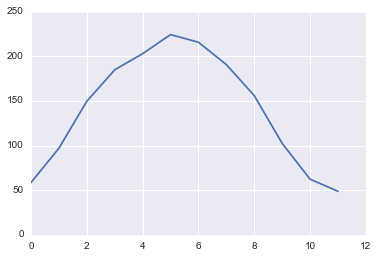

In [31]:
plt.plot(means.loc['ABO']['gre000z0'].values)

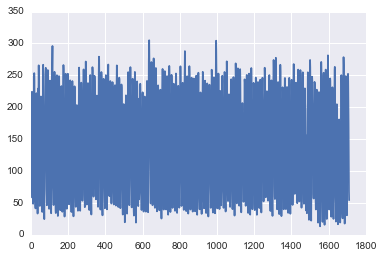

In [28]:
plt.plot(means.gre000z0.values)

## Add power from ELL model

Load trained model

In [32]:
model = pickle.load(open('model.p', 'rb'))

In [33]:
model

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

Predict power for avg irradiation in each month

In [35]:
irradiance_s = means.gre000z0.values

In [36]:
irradiance_s

array([  58.65241178,   97.04135745,  149.70530885, ...,  117.35456507,
         68.43722767,   54.28122482])

In [38]:
power_s = model.predict(irradiance_s.reshape(-1,1))

In [39]:
power_s

array([ 209.77315058,  343.8315876 ,  526.71839172, ...,  414.51352672,
        244.00243259,  194.46866485])

Add power column to DataFrame

In [41]:
means['power'] = power_s

In [43]:
means.head(12)

gre000z0       power
stn time                        
ABO 1      58.652412  209.773151
    2      97.041357  343.831588
    3     149.705309  526.718392
    4     184.841352  648.078605
    5     202.885559  710.199038
    6     224.238990  783.532850
    7     215.667876  754.120525
    8     190.617565  667.979356
    9     155.846557  547.968252
    10    102.394213  362.474469
    11     62.321814  222.614248
    12     48.701434  174.920762

## Conclusion

Now, we can predict that for each of the following years, we have such avg power produced per month and so we can estimate the break-even time

We can use this as our baseline.

## Next

Instead of using an average of monthly values, we could train a model for each month of each station, and then use it for future predictions.